# RL on the CartPole-V1 Gym environment 
>Pages 613-642, Ch 18, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.

- [Hardcoded policy](#Hardcoded-policy)
- [Policy Gradients REINFORCE](#NN-Policy-Gradients-REINFORCE)
- [Deep Q-Learning](#Deep-Q-Learning)

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [2]:
try: env
except NameError: env = None
if env is not None: env.close()

env = gym.make("CartPole-v1")
obs = env.reset()
list(zip(['Velocity', 'Position', 'Angle', 'Angular velocity'], obs))

[('Velocity', -0.009468447658954007),
 ('Position', 0.006884660973506061),
 ('Angle', 0.04254010262761253),
 ('Angular velocity', -0.038301621408187374)]

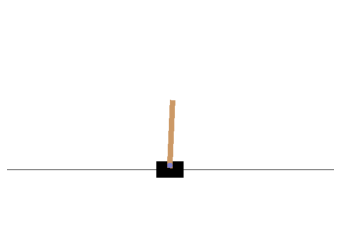

In [3]:
import matplotlib.pyplot as plt

img = env.render(mode='rgb_array')
_ = plt.imshow(img)
_ = plt.axis('off')

## Hardcoded policy

In [4]:
from time import sleep

render = False
policy = lambda obs: int(obs[2] > 0)  # Move to the same direction of the pole 

rewards = []
for episode in range(100):
    obs = env.reset()
    episode_reward = 0
    for step in range(200):
        action = policy(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        
        if render:
            env.render()
            sleep(0.001)
        if done:
            rewards.append(episode_reward)
            break    
            
print(f'Mean: {np.mean(rewards)}, Std: {np.std(rewards):.2f}, Min: {np.min(rewards)}, Max: {np.max(rewards)}'    )

Mean: 42.13, Std: 8.23, Min: 24.0, Max: 61.0


## NN Policy Gradients REINFORCE

1. First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely but don’t apply these gradients yet.
2. Once you have run several episodes, compute each action’s advantage (using the method described in the previous section).
3. If an action’s advantage is positive, it means that the action was probably good, and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the action’s advantage is negative, it means the action was probably bad, and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the corresponding action’s advantage.
4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a Gradient Descent step

### Create a model

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(16, activation='elu', input_shape=[env.observation_space.shape[0]]),
    Dense(1, activation='sigmoid'),  # Binary action, left or right
])

optimizer = Adam(lr=1e-2)
loss_fn = binary_crossentropy

### Breakdown of the problem in helper function steps

In [6]:
from time import sleep

def run_one_step(env: gym.Env, obs: np.ndarray,
                 model: tf.keras.Model, loss_fn: tf.keras.losses,
                 render: bool):
    """Run one step of the environment. Option to render with 100 fps.
    
    - Compute and record gradients assuming all taken actions are correct
    - Advance one step in the environment
    """
    
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = tf.random.uniform([1, 1]) > left_proba
        
        # Assume always correct. i.e. left action == 0 -> left proba == 1
        target_y = tf.constant([1.]) - tf.cast(action, tf.float32)
        loss = loss_fn(target_y, left_proba)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action))
    
    if render:
        env.render()
        sleep(0.01) # 100 fps
    
    return obs, reward, done, gradients


def run_episodes(env: gym.Env, n_episodes: int, n_max_steps: int,
                 model: tf.keras.Model, loss_fn: tf.keras.losses,
                 render: bool = False):
    """Run multiple episodes looping over run_one_step
    
    - Record rewards and gradients
    """
    
    all_gradients = []
    all_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        episode_gradients = []
        episode_rewards = []
        for step in range(n_max_steps):
            obs, reward, done, gradients = run_one_step(env, obs, model, loss_fn, render)

            episode_rewards.append(reward)
            episode_gradients.append(gradients)

            if done:
                break
                
        all_rewards.append(episode_rewards)       
        all_gradients.append(episode_gradients)
                
    return all_gradients, all_rewards
  

def discount_all_rewards(all_rewards: '2D arary', gamma):
    """Discount rewards (list of lists) with factor gamma"""
    
    all_discounted_rewards = []    
    for episode_rewards in all_rewards:
        discounted_rewards = [episode_rewards[-1]]
        for i in range(len(episode_rewards) - 1):
            discounted_rewards.append(episode_rewards[-i + 1] + gamma*discounted_rewards[i])
        discounted_rewards.reverse()
        
        all_discounted_rewards.append(discounted_rewards)
   
    return all_discounted_rewards


def normalize_all_rewards(all_rewards: '2D array'):
    """Normalize rewards (list of lists)"""   
    
    all_norm_rewards = []
    for episode_rewards in all_rewards:
        rewards_mean = np.mean(episode_rewards)
        rewards_std = np.std(episode_rewards)
        
        normed_episode_rewards = (np.array(episode_rewards) - rewards_mean ) / rewards_std
        
        all_norm_rewards.append(normed_episode_rewards)
    
    return all_norm_rewards


def report_stats(rewards):
    rewards = [sum(reward) for reward in rewards]
    rewards = np.array(rewards)
    return f'Mean: {np.mean(rewards)}, Std: {np.std(rewards):.2f}, Min: {np.min(rewards)}, Max: {np.max(rewards)}'    

### Stiching it all together

In [7]:
train_steps = 101
gamma = 0.95  # discount factor

n_episodes = 5  # episodes per training step
n_max_steps = 200  # max number of steps per episode, 200 for CartPole

for train_step in range(train_steps):
    gradients, rewards = run_episodes(env=env, n_episodes=n_episodes, n_max_steps=n_max_steps, 
                                      model=model, loss_fn=loss_fn, render=False)
    
    if not train_step%10:
        print(f'Iteration {train_step}/{train_steps}: {report_stats(rewards)}')
    
    discounted_rewards = discount_all_rewards(rewards, gamma)
    normalized_rewards = normalize_all_rewards(discounted_rewards)
    
    all_gradients = []
    for var_index in range(len(model.trainable_variables)):
        var_gradients = []
        for episode_rewards, episode_gradients in zip(normalized_rewards, gradients):
            for step_reward, step_gradients in zip(episode_rewards, episode_gradients):
                var_gradients.append(step_reward*step_gradients[var_index])
                
        var_gradients = np.mean(var_gradients, axis=0)
        all_gradients.append(var_gradients)
                
    optimizer.apply_gradients(zip(all_gradients, model.trainable_variables))

Iteration 0/101: Mean: 14.6, Std: 3.01, Min: 11.0, Max: 20.0
Iteration 10/101: Mean: 21.6, Std: 12.52, Min: 11.0, Max: 45.0
Iteration 20/101: Mean: 24.4, Std: 7.39, Min: 15.0, Max: 36.0
Iteration 30/101: Mean: 39.6, Std: 22.95, Min: 18.0, Max: 79.0
Iteration 40/101: Mean: 56.8, Std: 32.89, Min: 27.0, Max: 116.0
Iteration 50/101: Mean: 105.6, Std: 22.01, Min: 81.0, Max: 144.0
Iteration 60/101: Mean: 105.0, Std: 19.50, Min: 81.0, Max: 137.0
Iteration 70/101: Mean: 158.6, Std: 65.08, Min: 32.0, Max: 200.0
Iteration 80/101: Mean: 200.0, Std: 0.00, Min: 200.0, Max: 200.0
Iteration 90/101: Mean: 188.4, Std: 23.20, Min: 142.0, Max: 200.0
Iteration 100/101: Mean: 194.2, Std: 11.60, Min: 171.0, Max: 200.0


### Visualizing the learned model

In [8]:
# NOTE: you need to have a display to see the result
_, all_rewards = run_episodes(env, n_episodes=1, n_max_steps=n_max_steps,
                              model=model, loss_fn=loss_fn, render=True)

print(f'{int(sum(all_rewards[0]))}/{n_max_steps}')

200/200


## Deep Q-Learning

Approximate Q learning using the equation
> $Q_{target}\left( s,a \right) = r + \gamma \cdot \max_{a'} Q_{\Theta}\left( s',a' \right)$

where $\left( s,a \right)$ is the state action pair, $\gamma$ a discount factor. $\max_{a'}$ indicates that we choose the Q-Value given the optimal action. Our NN will model a function that returns the Q-Value given a certain state action pair.

This function can be applied iteratively. The objective is to minimize $Q_{target}\left( s,a \right) - \left( r + \gamma \cdot \max_{a'} Q_{\Theta}\left( s',a' \right)\right)$.

Example:

$S_0$ -> r+=0 -> $S_1$ 

$S_0$ -> r+=1 -> $S_2$ 

### The model

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.losses import huber
from tensorflow.keras.optimizers import Adam

N_OUTPUTS = 2  # Q-Value for every possible action (Left and right)

model = Sequential([
    Dense(32, activation='elu', input_shape=[env.observation_space.shape[0]], use_bias=False),
    BatchNormalization(),
    Dense(32, activation='elu', use_bias=False),
    BatchNormalization(),
    Dense(N_OUTPUTS, activation='linear'),
])

optimizer = Adam(lr=1e-3)
loss_fn = huber

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                128       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1024      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 1,474
Trainable params: 1,346
Non-trainable params: 128
_________________________________________________________________


### Memory
We need some memory to play back actions from.

In [30]:
from collections import deque

MEMORY = deque(maxlen=10000)

### Custom reward function
This sample code below can be activated to test what happens when a continuous reward is given. 

In [31]:
CUSTOM_REWARD = True  # Set to true if you want to try it out

def custom_reward(obs):
    """Custom reward that takes into the angle and distance from the center into account
    in a continous manner
    
    Based on:
    
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    
    source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py    
    """
    
    position_reward = 1 - abs(obs[0] / 2.4)
    velocity_reward = 1 / (1 + abs(obs[1]))
    angle_reward = 1 - abs(obs[2] / 0.418)
    angular_velocity_reward = 1 / (1 + abs(obs[3]))
    
    return position_reward + velocity_reward + angle_reward + angular_velocity_reward

### Breakdown of the problem in helper function steps

In [32]:
def epsilon_greedy_policy(model: tf.keras.Model, state: np.ndarray, epsilon: float):
    if np.random.rand() < epsilon:
        return np.random.randint(N_OUTPUTS)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])    
    
    
def sample_experiences(batch_size: int):
    
    indices = np.random.randint(len(MEMORY), size=batch_size)
    batch = [MEMORY[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array(elm) for elm in zip(*batch)]
    
    return states, actions, rewards, next_states, dones

def run_one_step(env: gym.Env, model: tf.keras.Model,
                 state: np.ndarray, epsilon: float):
    
    action = epsilon_greedy_policy(model, state, epsilon)
    next_state, reward, done, info = env.step(action)
    if CUSTOM_REWARD:
        reward = custom_reward(next_state)
    
    MEMORY.append((state, action, reward, next_state, done))
    
    return next_state, reward, done, info
    
def train_step(model: tf.keras.Model, target_model: tf.keras.Model, loss_fn: tf.keras.losses, optimizer: tf.keras.optimizers,
               batch_size: int, gamma: float):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Use the online model to select the best action
    next_Q_values = model.predict(next_states)
    next_best_actions = np.argmax(next_Q_values, axis=1)
    mask = tf.one_hot(next_best_actions, N_OUTPUTS).numpy()
    
    # Use the target model to compute the corresponding Q-Values
    next_best_Q_values = (target_model.predict(next_states) * mask).sum(axis=1)
    target_Q_values = (rewards + (1 - dones)*gamma*next_best_Q_values).reshape(-1, 1)
    
    # Mask for the Q-Values to the actions that we took
    mask = tf.one_hot(actions, N_OUTPUTS)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model, optimizer

### Combining it all into a trained double DQN

In [33]:
n_episodes = 1000
n_steps = 200
n_warmup = 50
min_epsilon = 0.01

double_q = True  # DQN use a target model and an online model

batch_size = 128
gamma = 0.5 if CUSTOM_REWARD else 0.95

steps = []
for episode in tqdm(range(n_episodes)):
    if episode%10 == 0 and double_q:
        target_model = tf.keras.models.clone_model(model)
        target_model.set_weights(model.get_weights())
    elif not double_q:
        target_model = model
    
    state = env.reset()
    
    epsilon = max(1 - episode / (n_episodes - 100), min_epsilon)
    for step in range(n_steps):
        state, reward, done, info = run_one_step(env, model, state, epsilon)
        if done:
            steps.append(step)
            break
            
    # Early stopping
    if sum(steps[-10:])/10 > 180:
        break
    
    if episode > n_warmup:
        model, optimizer = train_step(model, target_model, loss_fn, optimizer, batch_size, gamma)    

100%|██████████| 1000/1000 [28:11<00:00,  1.69s/it]


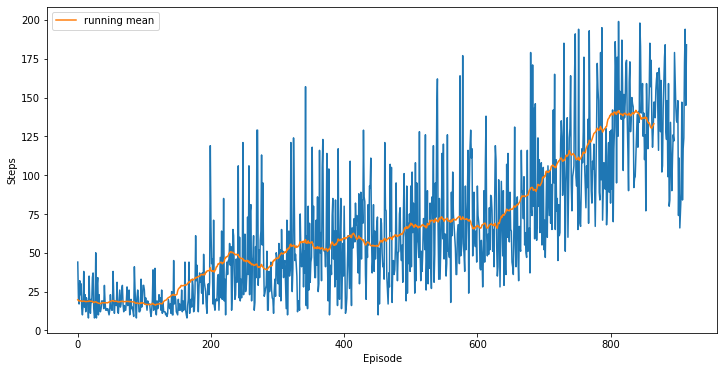

In [43]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(steps)
ax.plot(np.convolve(steps, np.ones(50)/50, mode='valid'), label='running mean')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps')
ax.legend()
plt.show()

Seems to learn in a robust way